In [7]:
N_refines.size

6

/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


---------------------------------
Solution misfit: 0.011882819221281066  dt: 0.05
---------------------------------
Solution misfit: 0.005831806396599088  dt: 0.025
---------------------------------
Solution misfit: 0.0028845804608949597  dt: 0.0125
---------------------------------
Solution misfit: 0.0014339345012653112  dt: 0.00625
---------------------------------
Solution misfit: 0.0007148112227730335  dt: 0.003125
---------------------------------
Solution misfit: 0.0003568580618774018  dt: 0.0015625


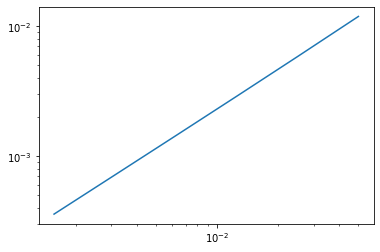

In [8]:
from dolfin import *
import numpy as np
parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True



N_refines = np.array([10,20,40,80,160,320])
dts = np.zeros((N_refines.size,1))
errors_result = np.zeros((N_refines.size,1))
i_ref = 0

for N_refine in N_refines:
    # Define mesh
    N_mesh = N_refine
    mesh = UnitIntervalMesh(N_mesh)
    #mesh = RectangleMesh(Point(0., 0.), Point(1., 0.1), 50, 5)

    tol = 1E-12
    # Sub domain for clamp at left end
    def left(x, on_boundary):
        return near(x[0], 0.,tol) and on_boundary

    # Sub domain for rotation at right end
    def right(x, on_boundary):
        return near(x[0], 1.,tol) and on_boundary

    def left_and_right(x, on_boundary):
        return on_boundary

    # Create mesh function over the cell facets
    boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_subdomains.set_all(0)
    force_boundary = AutoSubDomain(right)
    force_boundary.mark(boundary_subdomains, 3)

    # Define measure for boundary condition integral
    dss = ds(subdomain_data=boundary_subdomains)

    E = Constant(70e3)
    nu = Constant(0.3)
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2./(1+nu)
    sig0 = Constant((1e0))  # yield strength
    Et = E/100.  # tangent modulus
    H = E*Et/(E-Et)  # hardening modulus
    rho = Constant(10e4)

    Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
    Nincr = N_refine*2
    # Nincr = 100
    load_steps = np.linspace(0, 1, Nincr+1)[1:]

    dt = Constant(load_steps[1]-load_steps[0])
    dt_ = float(dt)

    # Newmark-beta method
    betaN = Constant(0.25)
    gammaN = Constant(0.5)

    deg_u = 2
    deg_stress = 2
    V = FunctionSpace(mesh, "CG", deg_u)
    We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=1, quad_scheme='default')
    W = FunctionSpace(mesh, We)
    W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
    W0 = FunctionSpace(mesh, W0e)
    # Define function space for stresses
    Vsig = VectorFunctionSpace(mesh, "DG", 0)

    sig = Function(W)
    sig_old = Function(W)
    beta = Function(W0)
    beta1 = Function(V)
    gamma0 = Function(W0)
    gamma0.interpolate(Constant(1e-6))
    u = Function(V, name="Total displacement")
    u_pre = Function(V)
    u_old = Function(V)
    u_d_old = Function(V)
    u_dd_old = Function(V)
    du = Function(V, name="Iteration correction")
    Du = Function(V, name="Current increment")
    v = TrialFunction(V)
    u_ = TestFunction(V)

    u_theo = Function(V)

    sig_out = Function(Vsig, name="sigma")
    eps_out = Function(Vsig, name="epsilon")

    # Set up boundary condition at left end
    # bc_expression = Expression( ("t <= tc ? x[0]*1e-6*pow(t,1) : x[0]*0.5e-6"), tc=0.5, t=0, degree=2) # Constant(0.0)
    # t*x[0]*(1-t*x[0]/L)/L -BC1
    # t*x[0]*(1-t*x[0]*x[0]/L)/L -BC2
    # t*t*x[0]*(1-x[0]*x[0]*t/L)/L - BC3
    # "t*t*x[0]*(1-x[0]*x[0]/L)/L" - 0 BC
    bc_expression = Expression(("t*t*x[0]*(1-x[0]*x[0]*t/L)/L"), L=1, t=0, degree=2)
    bc = DirichletBC(V, bc_expression, left_and_right)    

    zero = Constant(0.0)
    bc_newton = DirichletBC(V, zero, left_and_right)

    # bc = [DirichletBC(V.sub(1), 0, facets, 1), DirichletBC(V.sub(0), 0, facets, 3)]
    n = FacetNormal(mesh)

    q_lim = float(2/sqrt(3)*sig0*mu*2)
    # loading = Expression("q*t", q=q_lim, t=0, degree=2)
    loading = Expression(("t <= tc ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=0.7, degree=2)

    # DEFINING SOURCE TERM
    # source = Expression(("t <= tc && x[0]<0.55 && x[0]>0.45  ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=1.2, degree=2)
    # source = Constant(0.0)

    # MMS - Nonlinear
    # "(2*eps0*eps0*(G0*t*t-rho*x[0]*x[0])*pow(L,4)-4*pow(L,3)*eps0*rho*t*x[0]*x[0]+8*t*t*(eps0*x[0]-1/4)*rho*pow(x[0],2)*L*L+8*L*rho*pow(t,3)*pow(x[0],3)-8*rho*pow(t,4)*pow(x[0],4))/(L*L*pow(L*L*eps0-2*t*t*x[0]+L*t,2))"
    # BC3 - Nonlinear
    # (2*(pow(L,5)*eps0*eps0*rho+3*t*eps0*eps0*(G0*t*t-rho*x[0]*x[0])*pow(L,4)+9*G0*L*L*pow(t,7)-54*G0*L*pow(t,8)*x[0]*x[0]+81*G0*pow(t,9)*pow(x[0],4)))*x[0]/(pow(eps0,2)*pow(L,6))

    # MMS - linear
    # (2*G0*t*t-2*rho*x[0]*x[0])/L/L - BC1
    # 6*x[0]*(G0*t*t-(1/3)*rho*x[0]*x[0])/L/L - BC2
    # 2*x[0]*(rho*(-3*t*x[0]*x[0]+L)+3*G0*pow(t,3))/L/L - BC3
    # (2*(rho*(-x[0]*x[0]+L)+3*G0*t*t))*x[0]/L/L - 0 BC case

    source = Expression(\
        ("(2*(pow(L,5)*eps0*eps0*rho+3*t*eps0*eps0*(G0*t*t-rho*x[0]*x[0])*pow(L,4)+9*G0*L*L*pow(t,7)-54*G0*L*pow(t,8)*x[0]*x[0]+81*G0*pow(t,9)*pow(x[0],4)))*x[0]/(pow(eps0,2)*pow(L,6))")\
        ,G0=float(mu), eps0=float(sig0), rho=float(rho), t=0, L=1, degree=2)

    # (2*eps0*eps0*(G0*t*t-rho*x*x)*pow(L,4)
    #  -4*pow(L,3)*eps0*rho*t*x*x
    #  +8*x*x*t*t*rho*(x*eps0-1/4)*L*L
    #  +8*L*rho*pow(t,3)*pow(x,3)
    #  -8*rho*pow(t,4)*pow(x,4)
    # )
    # /(L*L*pow(L*L*eps0-2*t*2*x+L*t,2))


    def F_ext(v):
        return dot(loading,v)*dss(3)
        # return loading*dot(n, v)*dss(3)

    # Update formula for acceleration
    # a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
    def update_a(u, u_old, v_old, a_old, ufl=True):
        if ufl:
            dt_ = dt
            betaN_ = betaN
        else:
            dt_ = float(dt)
            betaN_ = float(betaN)
        return (u-u_old-dt_*v_old)/betaN_/dt_**2 - (1-2*betaN_)/2/betaN_*a_old

    # Update formula for velocity
    # v = dt * ((1-gamma)*a0 + gamma*a) + v0
    def update_v(a, u_old, v_old, a_old, ufl=True):
        if ufl:
            dt_ = dt
            gamma_ = gammaN
        else:
            dt_ = float(dt)
            gamma_ = float(gammaN)
        return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

    def update_fields(u, u_old, v_old, a_old):
        """Update fields at the end of each time step."""

        # Get vectors (references)
        u_vec, u0_vec  = u.vector(), u_old.vector()
        v0_vec, a0_vec = v_old.vector(), a_old.vector()

        # use update functions using vector arguments
        a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
        v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

        # Update (u_old <- u)
        v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
        u_old.vector()[:] = u.vector()

    def eps(v):
        e = 0.5*grad(v)
        return e

    def sigma(eps_el):
        return 2*mu*eps_el

    def sigma_out(r):
        return 2.0*mu*sym(grad(r))

    def proj_sig(old_u,old_sig,old_Du):
        eps_old = eps(old_u)
        beta = sig0/(abs(eps_old[0])+sig0)
        # beta = 1
        beta = 1+3*(2*eps_old[0]/sig0)*(2*eps_old[0]/sig0)
        # beta = gamma0
        # beta /= (eps_old[0]+as_tensor(gamma0[0]))
        return 2*mu*beta*eps(old_Du)+old_sig, beta

    def sigma_tang(e):
        return 2*mu*beta*e

    metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
    dxm = dx(metadata=metadata)

    # a_Newton = inner(eps(v), sigma_tang(eps(u_)))*dxm

    # a_Newton = inner(eps(u_), sigma_tang(eps(v)))*dxm

    a_Newton = rho*inner(u_,v)/(betaN*dt*dt)*dxm + inner(2*eps(u_), sigma_tang(eps(v)) )*dxm
    # F_ext(u_) + \
    res = (-rho)*inner(u_,u)/(betaN*dt*dt)*dxm + \
          -inner(2*eps(u_), sig)*dxm + \
          F_ext(u_) + \
          inner(u_,source)*dxm + \
          rho*inner(u_old+dt*u_d_old,u_)*1./(betaN*dt*dt)*dxm + \
          (1.-2*betaN)/(2*betaN)*rho*inner(u_dd_old,u_)*dxm

    def local_project(v, V, u=None):
        dv = TrialFunction(V)
        v_ = TestFunction(V)
        a_proj = inner(dv, v_)*dxm
        b_proj = inner(v, v_)*dxm
        solver = LocalSolver(a_proj, b_proj)
        solver.factorize()
        if u is None:
            u = Function(V)
            solver.solve_local_rhs(u)
            return u
        else:
            solver.solve_local_rhs(u)
            return

    file_results = XDMFFile("nonlinearElas1DVeri__results.xdmf")
    file_results.parameters["flush_output"] = True
    file_results.parameters["functions_share_mesh"] = True

    results = np.zeros((Nincr+1, 5))
    results_1d = np.zeros((Nincr+1, N_mesh))

    # Initial conditions
    u_old.interpolate( Expression(("0"), degree=2) )
    u_d_old.interpolate( Expression(("0"), degree=2) )
    # u.assign(u_old)

    for (i, t) in enumerate(load_steps):
        loading.t = t
        bc_expression.t = t
        source.t = t

        u_pre.assign(u)

        # Prepare for U_n+1^0 from U_n
        bc.apply(u.vector())
        # print('U at the left and right:',u(0), " ", u(1))
        # print('Source at the left and right:',source(0), " ", source(1))
        # -- Compute components in F(U_n+1^0)
        Du.assign(u-u_pre)
        sig_, beta_ = proj_sig(u_pre,sig_old,Du)
        local_project(sig_, W, sig)
        local_project(beta_, W0, beta)
        A, Res = assemble_system(a_Newton, res, bc_newton)

        nRes0 = Res.norm("l2")
        nRes = nRes0
        # print("Increment:", str(i+1),"   Initial Residual:", nRes0)
        niter = 0

        while (nRes/nRes0 > tol and nRes0>1e-10) and niter < Nitermax:
            solve(A, du.vector(), Res, "mumps")
            Du.assign(Du+du)
            u.assign(u+du) # u^{k+1}_{n+1}
            sig_, beta_ = proj_sig(u_pre,sig_old,Du)
            local_project(sig_, W, sig)
            local_project(beta_, W0, beta)
            A, Res = assemble_system(a_Newton, res, bc_newton)
            nRes = Res.norm("l2")
            # print("    Residual:", nRes," ",niter)
            niter += 1
        u.assign(u_pre+Du)

        update_fields(u, u_old, u_d_old, u_dd_old)

        sig_old.assign(sig)

    # ----------------
    # Post-processing
    # ----------------
    #
    # Inside the incremental loop, the displacement and plastic strains are exported
    # at each time increment, the plastic strain must first be projected onto the
    # previously defined DG FunctionSpace. We also monitor the value of the cylinder
    # displacement on the inner boundary. The load-displacement curve is then plotted::

        local_project(sig, Vsig, sig_out)
        local_project(eps(u), Vsig, eps_out)

        file_results.write(u, t)
        for i_x in range(N_mesh):
            results_1d[i+1,i_x] = u(i_x/(N_mesh-1))
        tc = 0.7;
        if t<tc:
            # results[i+1, :] = (u(1),t,4*t*(1-t))
            results[i+1, :] = (u(1), sig_out(1),t,4*t*(1-t),eps_out(1))
        else:
            results[i+1, :] = (u(1), sig_out(1),t,0,eps_out(1))

    print("---------------------------------")
    
    u_theo.interpolate(bc_expression)
    error = (u_theo - u)**2*dxm
    Errors_theo = sqrt(abs(assemble(error)))
    errors_result[i_ref] = Errors_theo
    dts[i_ref] = 1/Nincr
    i_ref += 1

    print("Solution misfit:", Errors_theo," dt:",1/Nincr)


In [14]:
# Convergence study
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

popt, pcov = curve_fit(func,np.log(dts),np.log(errors_result))

plt.loglog(dts,errors_result,'*')
plt.axis('equal')
plt.xlabel('dt')
plt.ylabel('RMS Errors')



ModuleNotFoundError: No module named 'scipy'

In [ ]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

In [ ]:
# MPII
# 2*float(mu)*float(sig0)*np.log(1+abs(results[:N_pt, 4])/float(sig0))\
#           *abs(results[:N_pt, 4])/results[:N_pt, 4]

# Simple case
# 2*float(mu)*results[:N_pt, 4]*(1+ (2*results[:N_pt, 4]/float(sig0))**2 )

N_pt = 500;
stress_theo = 2*float(mu)*results[:N_pt, 4]*(1+ (2*results[:N_pt, 4]/float(sig0))**2 )
stress_lin = 2*float(mu)*results[:N_pt, 4]

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.plot(results[:, 0], results[:, 1], "-*")
plt.plot(results[:, 0], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Displacement")
plt.ylabel("$\sigma_{xx,yy}$ at the right end")
plt.legend(["$\sigma_{yy}$","$\sigma_{xx}$","Loads"])
plt.subplot(1,4,2)
plt.plot(results[:, 2], results[:, 1], "-.")
plt.plot(results[:, 2], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Loading steps")
plt.ylabel("$\sigma_{xx}$ at the right end")
plt.legend(["$\sigma_{yy}$","Loads"])
plt.subplot(1,4,3)
plt.plot(results[:, 2], results[:, 0], "-.")
plt.xlabel("Time")
plt.ylabel("Displacement at the right end")
plt.subplot(1,4,4)

plt.plot(results[:N_pt, 4], results[:N_pt, 1], ".-")
plt.plot(results[:N_pt, 4], stress_theo, "-")
plt.plot(results[:N_pt, 4], stress_lin, "-")
plt.xlabel("Strain and the right end")
plt.ylabel("Stress at the right end")
plt.show()

In [ ]:
x_grid = np.linspace(0,1,N_mesh)
u_theo = x_grid/1*(1-x_grid**2/1)

In [ ]:
fig, ax = plt.subplots()

line1, = ax.plot([])
line2, = ax.plot([])

ax.set_xlim(0,1)
ax.set_ylim(-1e0,1e0)

ax.set_xlabel('x')
ax.set_ylabel('Displacement')

def animate(frame_num):
    # ax.clear()
    line1.set_data((np.linspace(0,1,N_mesh), results_1d[frame_num, :]))
    line2.set_data(x_grid,u_theo)
    return line1, line2

ani = FuncAnimation(fig, animate, frames=Nincr, interval=10)


plt.show()

